### Imports

In [1]:
import cv2
import torch
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
from PIL.ImageOps import invert

### Image preprocessing

In [2]:
test_image = '../test_image.jpg'

# convert to grayscale
img = Image.open(test_image).convert('L')
img = invert(img)
img = ImageEnhance.Contrast(img).enhance(2)
img = img.point(lambda p: p > 220 and 255)
img = img.filter(ImageFilter.SMOOTH)

# show image
img.show()

### Inference

In [3]:
# Get the model
model_path = '../models/best.pt' 
c_model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)
c_model.eval()

Using cache found in /home/tim/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-5-22 Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
Model summary: 212 layers, 20909508 parameters, 0 gradients, 48.0 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 48, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  

[         xmin         ymin        xmax         ymax  confidence  class  \
0  434.871277  1307.555420  569.192749  1401.229004    0.956473     13   
1  611.121033   754.038879  696.333618   992.091675    0.930205     12   
2  205.832428  1033.671265  310.442261  1154.876587    0.928128      4   
3  593.892212   500.304474  708.587158   666.869446    0.895378     13   
4  359.590332   351.532410  471.762939   449.783752    0.847059     14   
5  195.901581   611.758972  318.067780   784.135986    0.806754      6   
6  622.283081  1122.369507  717.749023  1228.273804    0.764354      9   

            name  
0       resistor  
1       inductor  
2       curr_src  
3       resistor  
4      voltmeter  
5  dc_volt_src_2  
6          diode  ]


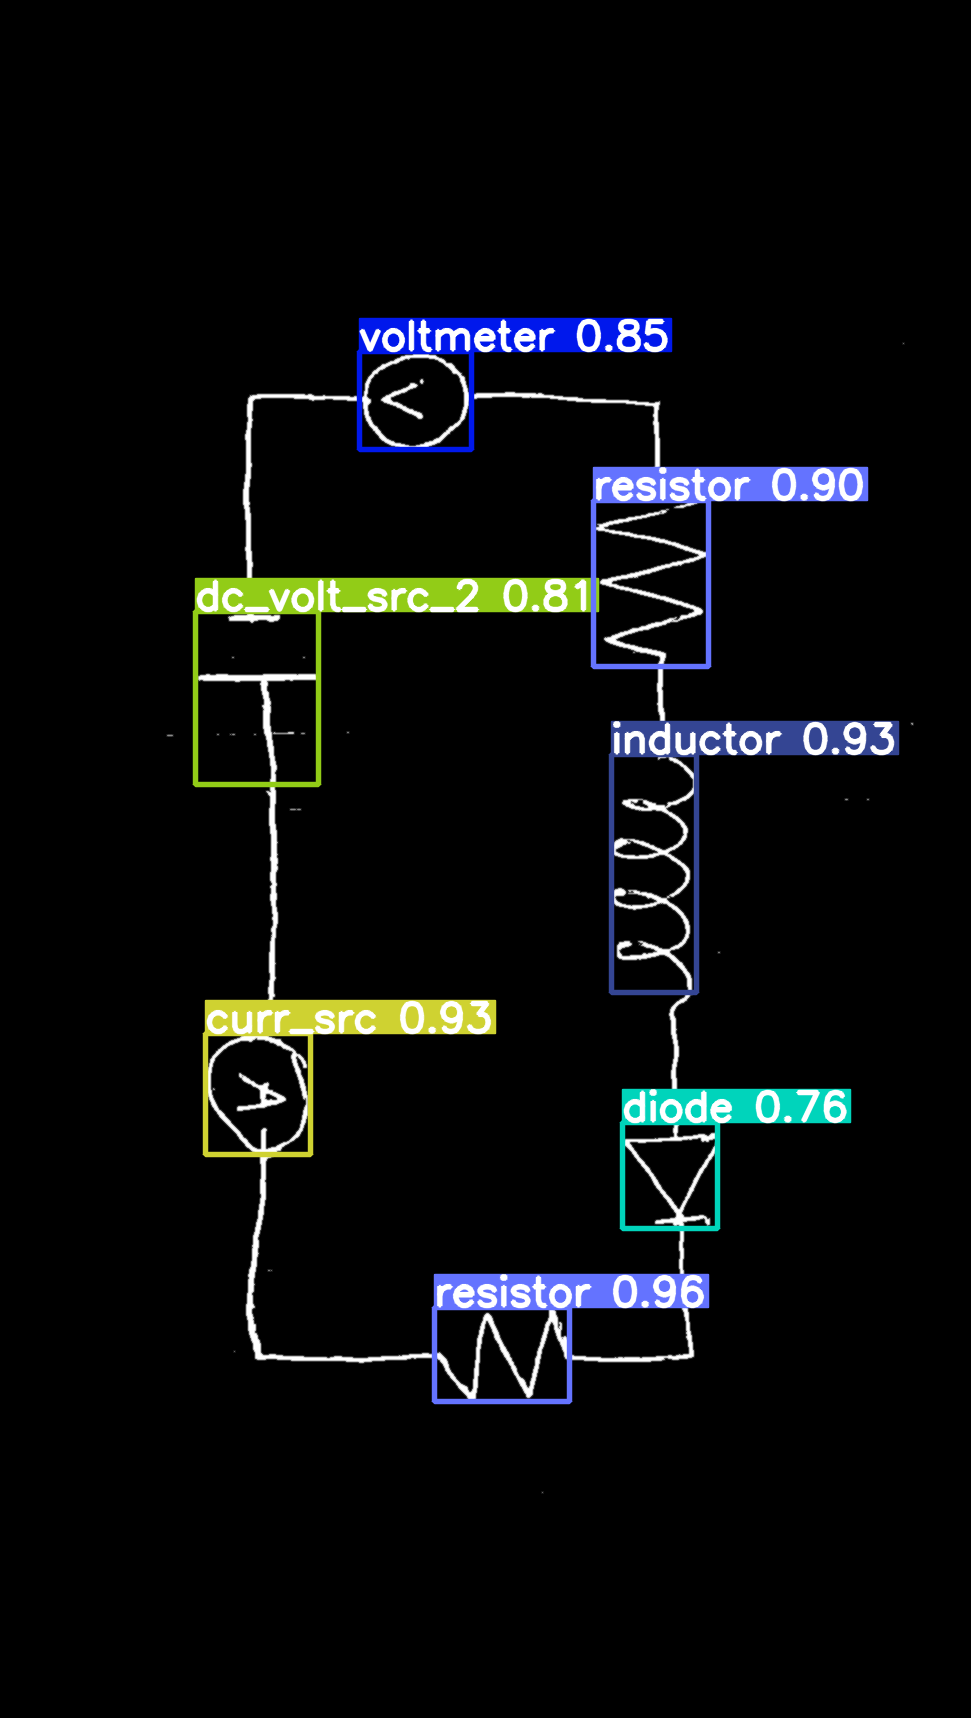

In [4]:
# Inference
results = c_model(img)

# Print and show results
print(results.pandas().xyxy)
results.show()

### Remove components

In [5]:
# Remove pixels in bounding boxing from image
def remove_pixels(image, results, padding=10):
    # Get bounding boxes
    boxes = results.xyxy[0]

    # Convert image to numpy array
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Add padding to image on all sides
    image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Remove pixels in bounding boxes
    for box in boxes:
        # Convert coordinates to integers
        x1, y1, x2, y2 = map(int, box[0:4])  
        # Add padding to the bounding boxes
        image[y1-padding:y2+padding, x1-padding:x2+padding] = 0

    # Remove padding
    image = image[padding:-padding, padding:-padding]

    # Convert image back to PIL image
    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    return image

# Remove pixels in bounding boxes
image = remove_pixels(img, results)

# Show image
image.show()

### Junction detection

In [6]:
# Get the model
model_path = '../models/junctions_best.pt'
j_model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)
j_model.eval()

Using cache found in /home/tim/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-5-22 Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
Model summary: 212 layers, 20885262 parameters, 0 gradients, 48.0 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 48, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  

[          xmin         ymin        xmax         ymax  confidence  class  \
0   231.842606   380.664886  268.391663   416.673767    0.526189      3   
1   647.940796   392.650818  669.114990   414.010803    0.509382      3   
2   229.897186   378.761139  268.715546   418.020874    0.499038      4   
3   664.693665   991.521118  687.286255  1013.280823    0.488918      4   
4   672.816956  1337.807617  711.873474  1374.778809    0.487494      1   
5   227.980042  1330.372559  285.848267  1387.330933    0.481137      0   
6   673.151123  1336.896729  711.839844  1375.754272    0.473646      0   
7   667.903809   987.045288  691.007263  1011.408630    0.451418      3   
8   230.036423  1330.493530  284.580719  1385.867188    0.435327      1   
9   645.691345   391.041321  670.451843   415.796265    0.373201      4   
10  236.852249  1132.819214  290.580261  1179.414795    0.334115      3   
11  239.454239  1128.015625  289.836700  1182.505127    0.293772      4   
12  653.699646   706.919

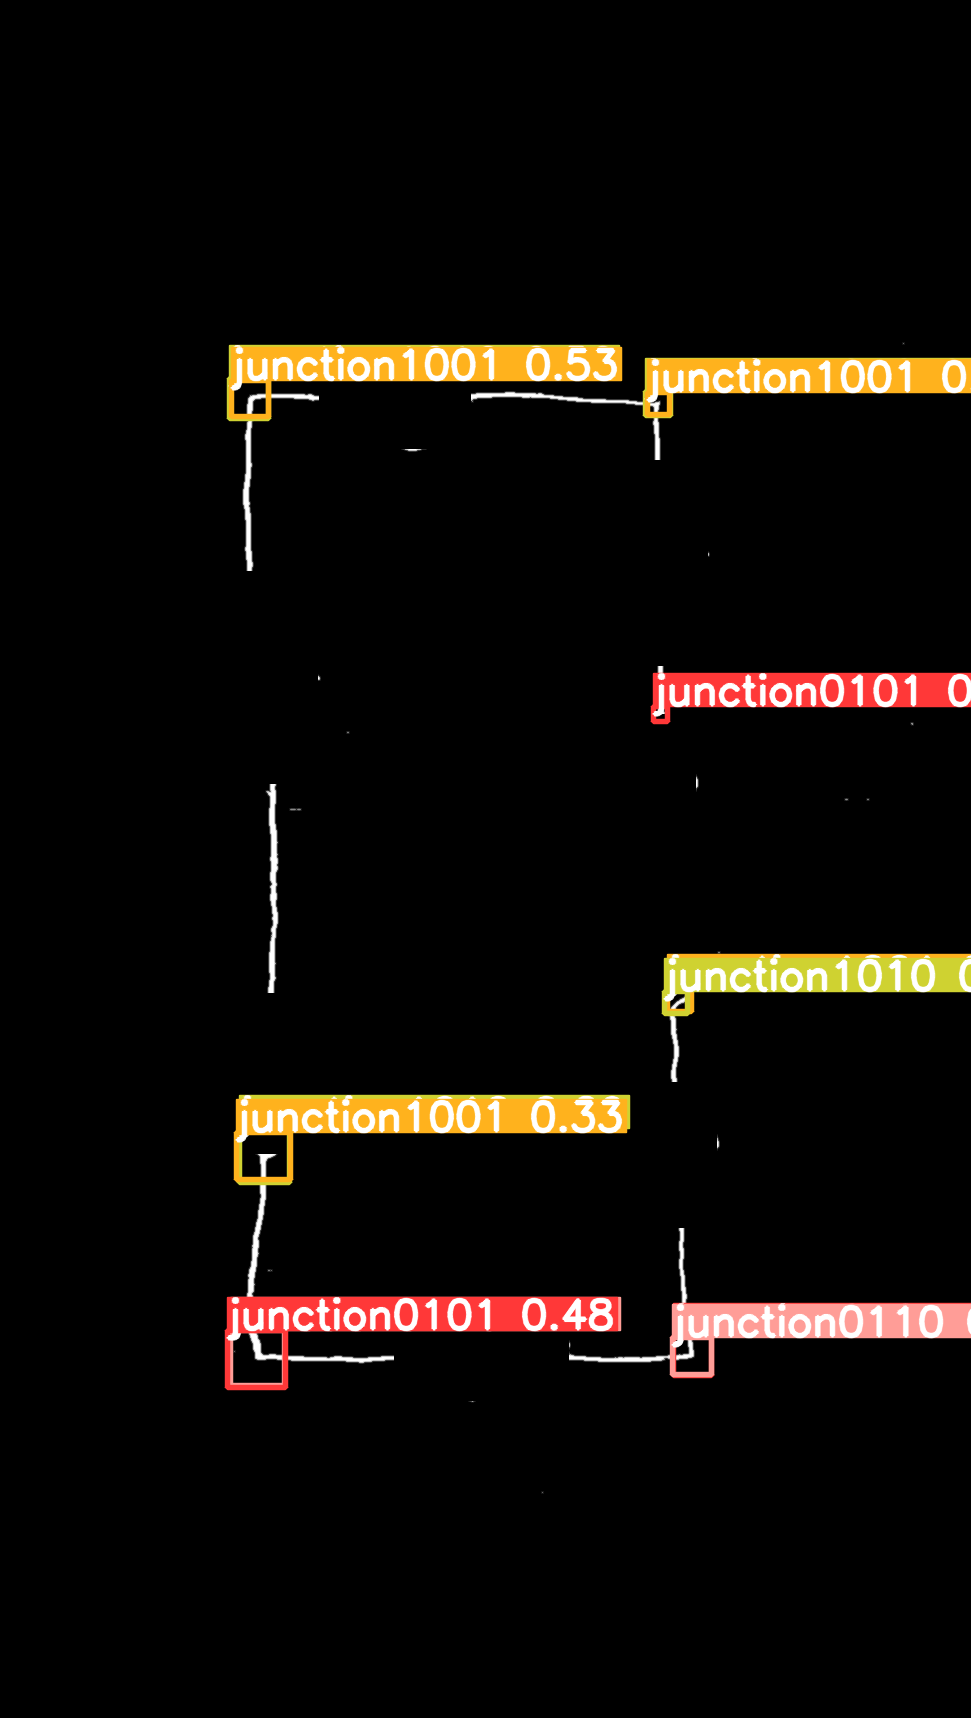

In [7]:
# Perform inference on the image without components
results = j_model(image)

# Print and show results
print(results.pandas().xyxy)
results.show()

### Line detection

In [8]:
# convert image to numpy array
image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

# convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# blur image
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# find edges in image
edges = cv2.Canny(gray, 50, 150)

# find lines in image
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=15, minLineLength=30, maxLineGap=10)

# draw lines on image
for points in lines:
    x1, y1, x2, y2 = points[0]
    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# convert image back to PIL image
image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# show image
image.show()

In [9]:
# Loop through all the lines and find all intersections
intersections = []

for i in range(len(lines)):
    for j in range(i+1, len(lines)):
        x1, y1, x2, y2 = lines[i][0]
        x3, y3, x4, y4 = lines[j][0]

        # Find intersection
        d = (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)
        if d:
            x = ((x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4))/d
            y = ((x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4))/d
            intersections.append((int(x), int(y)))
    
# Draw intersections on image
for point in intersections:
    cv2.circle(image, point, 5, (0, 0, 255), -1)

# convert image back to PIL image
image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# show image
image.show()

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'
